# Image Segmentation

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch08/8.1.Image_Segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
semantic segmentation - segment semantic categories (all people instances belong to same category)
instance segmantation - segment individual instances/objects (https://arxiv.org/abs/1703.06870)

#Tutorial https://neptune.ai/blog/image-segmentation-in-2020
# Unet: https://www.tensorflow.org/tutorials/images/segmentation

FCN
Fully convolutional networks for semantic segmenta-tion.
https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
# Converts the last fully con layer to a conv layer
# uses a deep jet technique to combine fuse local information to the coarse output

UNet
Uses FCN fully convolutional network
Encoder decoder

# Dialated FCN
# Converts all of CNNs to dialated CNNs
# Remove last two pooling layers leading to higher comp cplexity

FastFCN : https://arxiv.org/abs/1903.11816
# Backbone is the same as FCN
# Uses Joint Pooling (JPU) to create localized rep 
# Uses Encoding module to produce final output

# multi scale context module / PSPNet  https://arxiv.org/pdf/1612.01105.pdf

# bilinear interpolation
http://web.pdx.edu/~jduh/courses/geog493f09/Students/W6_Bilinear%20Interpolation.pdf
# weighted mean of n nearest points

use pretrained encoder
        
# losses 
# focal loss
# dice loss

https://github.com/qubvel/segmentation_models#models-and-backbones
https://tfhub.dev/s?module-type=image-segmentation
    
#metrics 
#pixel accuracy
# mean pixel IoU https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU

# What the chapter covers

# Understanding segmentation problem
# FCN architecture
# Training the FCN
# Fast FCN
#   Joint pyramid upsampling
#   Less complex final output prediction
# Describe losses
# Metric
# Training the new model

# survey
https://arxiv.org/pdf/2001.05566.pdf

SyntaxError: invalid syntax (<ipython-input-1-4739ff41fa47>, line 1)

In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

2.2.1


In [2]:
%ls data

 Volume in drive C has no label.
 Volume Serial Number is CA84-4503

 Directory of C:\Users\thush\Documents\code\manning_tf2_in_action\Ch08\data

11/11/2020  08:34 PM    <DIR>          .
11/11/2020  08:34 PM    <DIR>          ..
11/11/2020  08:29 PM    <DIR>          VOCtrainval_11-May-2012
11/11/2020  02:09 PM     1,999,639,040 VOCtrainval_11-May-2012.tar
               1 File(s)  1,999,639,040 bytes
               3 Dir(s)  310,551,097,344 bytes free


# Downloading and extracting the data

Cannot use https://www.tensorflow.org/datasets/catalog/voc, this is only for classification/detection
There're some segmentation datasets https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet, but not voc

In [3]:
# Downloading the data
#http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data
import os
import requests
import tarfile

# Retrieve the data
if not os.path.exists(os.path.join('data','VOCtrainval_11-May-2012.tar')):
    url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'wb') as f:
        f.write(r.content)
else:
    print("The tar file already exists.")
    
if not os.path.exists(os.path.join('data', 'VOCtrainval_11-May-2012')):
    with tarfile.open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'r') as tar:
        tar.extractall('data')
else:
    print("The extracted data already exists")


The tar file already exists.
The extracted data already exists


## Load and visualize a single annotated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


JPEG
This image is of size: (375, 500, 3)
(375, 500)


(-0.5, 499.5, 374.5, -0.5)

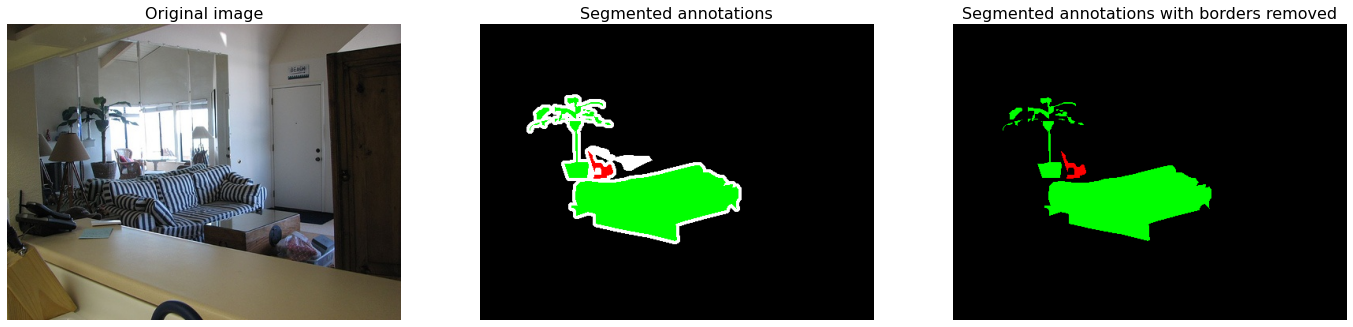

In [4]:
from PIL import Image
from PIL.PngImagePlugin import PngImageFile
import matplotlib.pyplot as plt

orig_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages', '2007_000661.jpg')
annot_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass', '2007_000661.png')
                                
orig_image = Image.open(orig_image_path)
print(orig_image.format)
orig_image = np.array(orig_image)
print("This image is of size: {}".format(orig_image.shape))

annot_image = Image.open(annot_image_path)
print(np.array(annot_image).shape)
def rgb_image_from_pallette(image, pallette):
    """ This function restores the RGB values form a palletted PNG image """
    # Convert the pallet to a sequence of RGB values (n, 3) shape
    pallette = np.array(pallette).reshape(-1,3)
    if isinstance(image, PngImageFile):
        h, w = image.height, image.width
        # Squash height and width dimensions (makes slicing easier)
        image = np.array(image).reshape(-1)
    elif isinstance(image, np.ndarray):
        h, w = image.shape[0], image.shape[1]
        image = image.reshape(-1)
        
    rgb_image = np.zeros(shape=(image.shape[0],3))
    
    # For all locations where image value is not zero, 
    # we replace those locations in the RGB image with the corresponding values from the pallette
    rgb_image[(image != 0),:] = pallette[image[(image != 0)], :]
    rgb_image = rgb_image.reshape(h, w, 3)
    
    return rgb_image

def remove_white_pixels(image, pallette):
    """ White pixels are either border or unknown objects, both of which we're not interested in """
    # 255 - void category, used for border regions (5px) and to mask difficult objects
    img_arr = np.array(image)
    row_idx, col_idx = np.nonzero((img_arr==255))
    
    rgb_image = rgb_image_from_pallette(image, pallette)    
    rgb_image[row_idx, col_idx, :] = 0
    return rgb_image

pallette = annot_image.getpalette()
annot_rgb_image = rgb_image_from_pallette(annot_image, pallette)
annot_no_border_image = remove_white_pixels(annot_image, pallette)

plt.subplots(1,3, figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(orig_image)
plt.title("Original image", fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(annot_rgb_image)
plt.title("Segmented annotations", fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(annot_no_border_image)
plt.title("Segmented annotations with borders removed", fontsize=16)
plt.axis('off')

In [5]:
# Classes 1 - 21 ( 0 - Background)
VOC_CLASSES = ['Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat',
               'Bottle', 'bus', 'Car', 'Cat', 'Chair', 'Cow',
               'Dining table', 'Dog', 'Horse', 'Motorbike', 'Person',
               'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/Monitor']


## Input data pipeline

Try setting up the pipeline without resizing images

```
InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [375,500,3] and element 1 had shape [333,500,3]. [Op:IteratorGetNext]
```

In [45]:
import glob
from functools import partial


# run a verification to make sure orig dir and seg dir only contains images with same aname

def get_subset_filenames(orig_dir, seg_dir, subset_dir, subset):
    
    if subset.startswith('train'):
        ser = pd.read_csv(os.path.join(subset_dir, "train.txt"), index_col=None, header=None, squeeze=True).tolist()
    elif subset.startswith('val'):
        ser = pd.read_csv(os.path.join(subset_dir, "trainval.txt"), index_col=None, header=None, squeeze=True).tolist()
    elif subset.startswith('test'):
        ser = pd.read_csv(os.path.join(subset_dir, "val.txt"), index_col=None, header=None, squeeze=True).tolist()
        
    orig_filenames = [os.path.join(orig_dir,f+'.jpg') for f in ser]
    seg_filenames = [os.path.join(seg_dir, f+'.png') for f in ser]
    
    for o, s in zip(orig_filenames, seg_filenames):
        yield o, s
    
    
batch_size = 4

orig_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages')
seg_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass')
subset_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'ImageSets', "Segmentation")


n_train = len(pd.read_csv(os.path.join(subset_dir, "train.txt"), index_col=None, header=None, squeeze=True).tolist())/batch_size
n_valid = len(pd.read_csv(os.path.join(subset_dir, "trainval.txt"), index_col=None, header=None, squeeze=True).tolist())/batch_size
print("Found {} training batches".format(n_train))
print("Found {} validation batches".format(n_valid))

partial_subset_fn = partial(get_subset_filenames, orig_dir=orig_dir, seg_dir=seg_dir, subset_dir=subset_dir)
train_subset_fn = partial(partial_subset_fn, subset='train')
val_subset_fn = partial(partial_subset_fn, subset='val')
test_subset_fn = partial(partial_subset_fn, subset='test')

def get_subset_tf_dataset(gen_func, batch_size, epochs, augmentation=False, shuffle=False):
    filename_ds = tf.data.Dataset.from_generator(
        gen_func, output_types=(tf.string, tf.string)
    )

    def load_image_func(image):

        img =  np.array(Image.open(image))
        # Avoiding void class
        #row_idx, col_idx = np.nonzero((img==255)) 
        #img[row_idx, col_idx] = 0
        return img


    image_ds = filename_ds.map(lambda x,y: (
        tf.io.decode_jpeg(tf.io.read_file(x)), 
        tf.numpy_function(load_image_func, [y], [tf.uint8])
    ))
    
    image_ds = image_ds.map(lambda x, y: (tf.cast(x, 'float32')/255.0, y))
    
    # This is an important step. Basically if you want to batch data, they should have the same shape
    image_ds = image_ds.map(lambda x,y: (
        tf.image.resize_with_pad(x, 572, 572, method='nearest'), 
        tf.cast(tf.image.resize_with_pad(tf.transpose(y,[1,2,0]), 388, 388, method='nearest'),'float32')
    ))
    
    def fix_shape(x, y):
        x.set_shape((572, 572, 3))
        y.set_shape((388, 388, 1))
        return x, y
    
    image_ds = image_ds.map(lambda x,y: fix_shape(x,y))
    
    
    def randomly_flip_horizontal(x, y):
        
        rand = np.random.uniform(0.0,1.0)
        
        if rand < 0.5:
            x, y = tf.image.flip_left_right(x), tf.image.flip_left_right(y)            
        
        return x, y
    
    def randomly_translate(x, y):
        
        tx, ty = tf.random.uniform([],-50, 50),  tf.random.uniform([], -50, 50)
        
        x, y = tfa.image.translate(x, [tx, ty]), tfa.image.translate(y, [tx, ty])
        return x, y
    
    #if augmentation:
        #image_ds = image_ds.map(lambda x, y: randomly_flip_horizontal(x,y))
        #image_ds = image_ds.map(lambda x, y: randomly_translate(x,y))
    
    
    
    # Convert to class 
    if shuffle:
        image_ds = image_ds.shuffle(buffer_size=batch_size*5)
    
    image_ds = image_ds.batch(batch_size).repeat(epochs)
    
    image_ds = image_ds.map(lambda x, y: (x, tf.squeeze(y)))
    
    return image_ds

epochs = 25
tr_image_ds = get_subset_tf_dataset(train_subset_fn, batch_size, epochs, shuffle=True)
val_image_ds = get_subset_tf_dataset(val_subset_fn, batch_size, epochs, shuffle=False)

print(tf.data.DatasetSpec.from_value(tr_image_ds))

for i, j in tr_image_ds.take(2):
    print("Input: {}, Target: {}".format(i.shape, j.shape))
    print(tf.reduce_max(j))
for i, j in val_image_ds.take(2):
    print("Input: {}, Target: {}".format(i.shape, j.shape))
    
tr_image_ds = get_subset_tf_dataset(train_subset_fn, batch_size, epochs, augmentation=True, shuffle=True)
val_image_ds = get_subset_tf_dataset(val_subset_fn, batch_size, epochs, shuffle=False)
test_image_ds = get_subset_tf_dataset(test_subset_fn, 1, 1, shuffle=False)

Found 366.0 training batches
Found 728.25 validation batches
DatasetSpec((TensorSpec(shape=(None, 572, 572, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)), TensorShape([]))
Input: (4, 572, 572, 3), Target: (4, 388, 388)
tf.Tensor(255.0, shape=(), dtype=float32)
Input: (4, 572, 572, 3), Target: (4, 388, 388)
tf.Tensor(255.0, shape=(), dtype=float32)
Input: (4, 572, 572, 3), Target: (4, 388, 388)
Input: (4, 572, 572, 3), Target: (4, 388, 388)


In [46]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()

num_classes = 21

def downsample_layer(inp, filters, downsample=True, with_bn=True):
    
    if downsample:
        inp = layers.MaxPooling2D((2,2), strides=(2,2))(inp)
        
    conv1_out = layers.Conv2D(filters, (3,3), activation='relu', padding='valid')(inp)
    if with_bn:
        conv1_out = layers.BatchNormalization()(conv1_out)    
    
    conv2_out = layers.Conv2D(filters, (3,3), activation='relu', padding='valid')(conv1_out)
    if with_bn:
        conv2_out = layers.BatchNormalization()(conv2_out)
    out = conv2_out
    
    return out

with_bn = True
inp = layers.Input(shape=(572, 572, 3))
scale_factor = 8
down_1 = downsample_layer(inp, 64/scale_factor, downsample=False, with_bn = with_bn)


down_2 = downsample_layer(down_1, 128/scale_factor, with_bn = with_bn)

down_3 = downsample_layer(down_2, 256/scale_factor, with_bn = with_bn)


down_4 = downsample_layer(down_3, 512/scale_factor, with_bn = with_bn)

down_5 = downsample_layer(down_4, 1024/scale_factor, with_bn = with_bn)

def upsample_conv(inp, copy_and_crop, filters, with_bn=False):
    
    conv1_out = layers.Conv2DTranspose(filters, (2,2), (2,2), activation='relu')(inp)
    cropped_copy = layers.Cropping2D(int((copy_and_crop.shape[1]-conv1_out.shape[1])/2))(copy_and_crop)
    concat_out = layers.Concatenate(axis=-1)([conv1_out, cropped_copy])
    
    conv2_out = layers.Conv2D(filters, (3,3), activation='relu', padding='valid')(concat_out)
    if with_bn:
        conv2_out = layers.BatchNormalization()(conv2_out)
    
    out = layers.Conv2D(filters, (3,3), activation='relu', padding='valid')(conv2_out)
    if with_bn:
        out = layers.BatchNormalization()(out)
    
    
    return out

up_1 = upsample_conv(down_5, down_4, 512/scale_factor)

up_2 = upsample_conv(up_1, down_3, 256/scale_factor)

up_3 = upsample_conv(up_2, down_2, 128/scale_factor)

up_4 = upsample_conv(up_3, down_1, 64/scale_factor)

final_out = layers.Conv2D(num_classes, (1,1))(up_4)
#final_out = layers.Reshape([21,])(final_out)
model = models.Model(inp, final_out)

def dice_loss(y_true, y_pred, from_logits=False):
    smooth = 1.

    if from_logits:
        y_pred = tf.nn.softmax(y_pred)
        
    y_pred_f = tf.reshape(y_pred, [-1, num_classes])
        #print(y_true.shape)
    # Flatten
    #valid_mask = tf.reshape(tf.logical_and((y_true>0), (y_true <= num_classes - 1)), [-1])
    valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])
    y_true = tf.reshape(y_true, [-1])
    y_true_f = tf.one_hot(tf.cast(y_true, 'int32'), num_classes)
    
    y_weights = tf.reduce_sum(y_true_f, axis=0, keepdims=True)
    
    y_weights = (388*388.0 - y_weights) / (388*388.0)
    y_true_f = tf.boolean_mask(y_true_f, valid_mask, axis=0)
    y_pred_f = tf.boolean_mask(y_pred_f, valid_mask, axis=0)
    
    #y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f * y_weights)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    
    loss = 1 - score
    return loss


def ce_dice_loss(y_true, y_pred, from_logits=True):
    ##loss = 0.5 * tf.nn.sparse_softmax_cross_entropy_with_logits(tf.cast(y_true, 'int32'), y_pred) +\
    #        dice_loss(y_true, y_pred, from_logits=from_logits)
    loss = dice_loss(y_true, y_pred, from_logits=from_logits)
    return loss

def mean_iou(y_true, y_pred):

    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), 'float32')
    y_true = tf.cast(tf.argmax(y_true, axis=-1), 'float32')
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

from functools import partial
#loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits = False)
loss = ce_dice_loss
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.SGD(0.1, momentum=0.9)
mean_iou = tf.keras.metrics.MeanIoU(21)
model.compile(loss=loss, optimizer='adam')#, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 570, 570, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 8)  584         batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
def scheduler(epoch, lr):
  if epoch==0:
    return lr
  else:
    return lr * 0.5


#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.fit(
    tr_image_ds, steps_per_epoch=n_train,
    #validation_data=val_image_ds, validation_steps=n_valid, 
    epochs=epochs)#, callbacks=[callback])
#model.fit(x, y)

Epoch 1/25
366/366 [==============================] - 165s 451ms/step - loss: 0.9785
Epoch 2/25
366/366 [==============================] - 175s 478ms/step - loss: 0.9778
Epoch 3/25
366/366 [==============================] - 178s 486ms/step - loss: 0.9782
Epoch 4/25
180/366 [=============>................] - ETA: 1:29 - loss: 0.9756

In [ ]:
model.evaluate(test_image_ds)

[2]
[  0   1 255]
[2]
[  0  19 255]
[2]
[  0   4 255]
[2]
[  0  19 255]
[2]
[  0   2  15 255]
[2]
[  0  17 255]
[2]
[  0  20 255]
[2]
[  0  15 255]


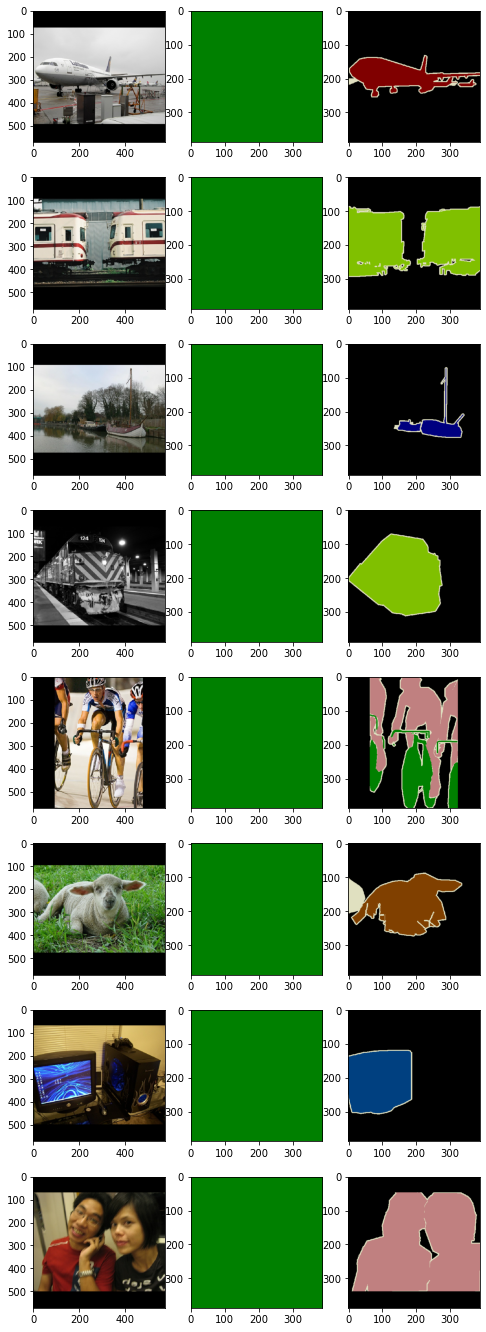

In [44]:
test_image_ds = get_subset_tf_dataset(test_subset_fn, 1, 1, shuffle=False)
plt.subplots(8, 3, figsize=(8,24))
i=0
for img, y_true in test_image_ds.take(8):
    
    img_pred = model.predict(img)

    y_pred = np.argmax(img_pred[0,:,:,:], axis=-1)
    print(np.unique(y_pred))
    y_true = y_true.numpy().astype('int')
    print(np.unique(y_true))
    y_rgb_pred = rgb_image_from_pallette(y_pred, pallette)
    y_rgb_true = rgb_image_from_pallette(y_true, pallette)
    
    plt.subplot(8,3,i*3+1)
    plt.imshow((img[0,:, :, :].numpy()*255).astype('uint8'))
    plt.subplot(8,3, i*3+2)
    plt.imshow(y_rgb_pred.astype('uint8'))
    plt.subplot(8,3, i*3+3)
    plt.imshow(y_rgb_true.astype('uint8'))
    
    i += 1
    
    
    
    